# Model creation and validation

The goal of this notebook: to choose the most suitable model for predicting branch points

In [1]:
from Bio import SeqIO
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

#sklearn utilites
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.model_selection import cross_val_score

#classifiers
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Input data

* GRCh37/hg19 genome assembly from http://hgdownload.cse.ucsc.edu/goldenpath/hg19/chromosomes/
* Introns coordinates from GENCODE v19 annotation from https://genome.ucsc.edu/cgi-bin/hgTables
* High confidence branchpoints from experimental work: Mercer, T. R., Clark, M. B., Andersen, S. B., Brunck, M. E., Haerty, W., Crawford, J., Taft, R. J., Nielsen, L. K., Dinger, M. E., & Mattick, J. S. (2015). Genome-wide discovery of human splicing branchpoints. Genome research, 25(2), 290–303. https://doi.org/10.1101/gr.182899.114

  Supplementary Table 1 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4315302/bin/supp_gr.182899.114_Supplemental_TableS1.xlsx


In [4]:
#reference genome
hg19 = SeqIO.to_dict(SeqIO.parse("input data/hg19.fa", "fasta"))

In [6]:
#introns positions
introns = pd.read_csv('input data/ann_gencode_v19.bed', sep = '\t', header = None, names = ['chr', 'start', 'stop', 'ID', 'score', 'strand'])
introns = introns[introns['chr'].isin(hg19.keys())]
introns.drop('ID', inplace=True, axis=1)
introns = introns.drop_duplicates()
introns

,chr,start,stop,score,strand
0,chr1,12227,12612,0,+
1,chr1,12721,13220,0,+
2,chr1,35174,35276,0,-
3,chr1,35481,35720,0,-
4,chr1,90050,90286,0,-
...,...,...,...,...,...
655354,chrY,59355880,59355972,0,+
655355,chrY,59355884,59355972,0,+
655356,chrY,59356131,59356790,0,+
655357,chrY,59356943,59357702,0,+


In [7]:
#high confidence banchpoints positions 
bp = pd.read_csv('input data/high_confidence_branchpoints.bed', sep = '\t', header = None, names = ['chr', 'start', 'stop', 'ID', 'score', 'strand'])
bp

,chr,start,stop,ID,score,strand
0,chr1,91661,91662,chr1_91661_91662_A,0,-
1,chr1,705123,705124,chr1_705123_705124_A,0,-
2,chr1,708510,708511,chr1_708510_708511_A,0,-
3,chr1,784824,784825,chr1_784824_784825_A,0,+
4,chr1,788027,788028,chr1_788027_788028_A,0,+
...,...,...,...,...,...,...
58854,chrY,59356757,59356758,chrY_59356757_59356758_C,0,+
58855,chrY,59356759,59356760,chrY_59356759_59356760_C,0,+
58856,chrY,59357674,59357675,chrY_59357674_59357675_A,0,+
58857,chrY,59357679,59357680,chrY_59357679_59357680_A,0,+


# Model development

In [8]:
def count_kmers(read, k):
    '''
    count k-mers distribution in read
    output: dictionary {k-mer:number of k-mer in this read}
    '''
    read = str(read).upper()
    counts = {}
    num_kmers = len(read) - k + 1
    for i in range(num_kmers):
        kmer = read[i:i+k]
        if 'N' in kmer: 
            continue
        if kmer not in counts:
            counts[kmer] = 0
        counts[kmer] += 1
    return counts

def kmers_pos(chrom, pos, n, k):
    '''
    count k-mers dist in (pos-n, pos+n)
    output: sorted by k-mer names disctionary {k-mer: number of k-mer in (pos-n, pos+n)}
    '''
    genom_chr = hg19[chrom]

    kmers = {}
    bp_round = genom_chr[pos-n:pos+n]
    cnt = count_kmers(bp_round.seq, k)

    kmers = Counter(cnt)
    kmers = dict(sorted(kmers.items()))
    
    return kmers

## Distance from branchpoints to 3' end

In [11]:
#calculate distribution of distance between 3' end and high confidence branchpoints in all chromosomes
dist_3 = []
for chrom in tqdm(hg19.keys()):
    
    introns_chrom = introns[introns['chr'] == chrom]
    dist_3_chrom = {}

    for i in range(len(introns_chrom)):
        start, stop, strand = introns_chrom.iloc[i]['start'], introns_chrom.iloc[i]['stop'], introns_chrom.iloc[i]['strand']
        for j in range(start, stop+1):
            if strand == '+':
                dist_3_chrom[j] = stop - j
            else:
                dist_3_chrom[j] = j - start
    
    bp_chrom = bp[bp['chr']==chrom]
    for i in range(len(bp_chrom)):
        for pos in range(bp_chrom.iloc[i]['start'], bp_chrom.iloc[i]['stop']):
            dist_3.append(dist_3_chrom[pos])

100%|██████████| 24/24 [24:21<00:00, 60.88s/it]


In [14]:
dist_3_counter = dict(sorted(Counter(dist_3).items()))

Text(0, 0.5, 'pdf')

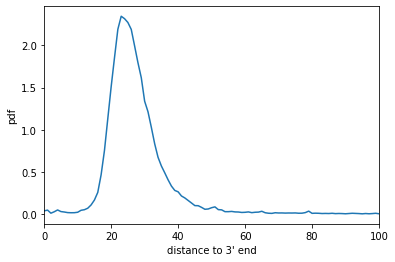

In [19]:
plt.plot(dist_3_counter.keys(), np.array(list(dist_3_counter.values()))/len(list(dist_3_counter.values())))
plt.xlim(0, 100)
plt.xlabel('distance to 3\' end')
plt.ylabel('pdf')

So, most of branchpoints are near to 3' end

## Introns length 

Text(0, 0.5, 'pdf')

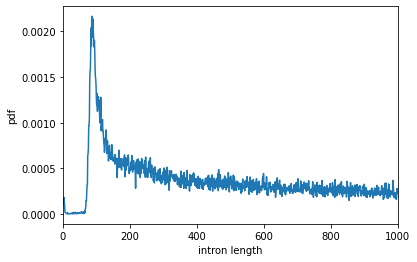

In [14]:
#calulate inton length distribution
int_len = introns['stop']-introns['start'] + 1
int_counter = dict(sorted(Counter(int_len).items()))
plt.plot(int_counter.keys(), np.array(list(int_counter.values())) / np.sum(list(int_counter.values())))
plt.xlim(0, 1000)
plt.xlabel('intron length')
plt.ylabel('pdf')

## Choose parameters (n, k) and classifier

Create model for branchpoints prediction. Table for ML looks as follows (where label=1 is branchpoint and label=0 is not branchpoint): 

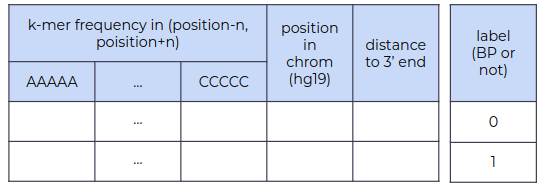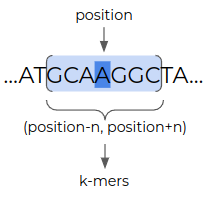

* As positive examples (label=1) we used experimental high confidence branchpoints
* As negative examples (label=0) we used random not high confidence BP positions from intron (We also tried to use examples only by 5' end, but this way model trained only on distance to 3' end and it considered the whole 3' end an intron. Moreover, training on 3' end negative examples gave worse results)




All files to plot graphs saved in folder `model development data`, so it is very fast to load them and get this data. 

In [9]:
def gen_test_n_k_chrom(n, k, chrom, X_3_dist = None, neg = None):
    '''
    calculate table for ML for defenite n, k and chromosome
    output: X and y for ML
    '''
    introns_chrom = introns[introns['chr'] == chrom]
    bp_chrom = bp[bp['chr']==chrom]
    
    #create table of k-mers for high confidence branchpoints in this chromosome
    X_bp = pd.DataFrame(columns = [''.join(i) for i in itertools.product('ATGC', repeat = k)])
    for i in tqdm(range(len(bp_chrom))):
        for pos in range(bp_chrom.iloc[i]['start'], bp_chrom.iloc[i]['stop']+1):
            X_bp = X_bp.append(kmers_pos(chrom, pos, n, k), ignore_index=True)
    X_bp['label'] = np.ones(len(X_bp))
    bps_coords = bp_chrom[['start', 'stop']].to_numpy()
    bps_coords = bps_coords.reshape(len(bps_coords)*2)
    X_bp.insert(loc=0, column='pos', value=bps_coords)

    if X_3_dist == None: 
        X_3_dist = {} #distance from position in intron to 3' end
        neg = [] #negaite examples (not high confidence branchpoints)
        
        for i in tqdm(range(len(introns_chrom))):
            start, stop, strand = introns_chrom.iloc[i]['start'], introns_chrom.iloc[i]['stop'], introns_chrom.iloc[i]['strand']
            for j in range(start, stop+1):
                if j not in bps_coords:
                    neg.append(j)
                if strand == '+': #start -> stop is 5' -> 3' 
                    X_3_dist[j] = stop - j
                else:             #start -> stop is 3' -> 5' 
                    X_3_dist[j] = j - start

    #choose the same number of negative examples (not branchpoints)
    negative_positions = [neg[i] for i in sample_without_replacement(n_population = len(neg), n_samples = len(X_bp))]
            
    #create table of k-mers for not branchpoints 
    X_gen = pd.DataFrame(columns = [''.join(i) for i in itertools.product('ATGC', repeat = k)])
    for pos in tqdm(negative_positions):
        X_gen = X_gen.append(kmers_pos(chrom, pos, n, k), ignore_index=True)
    X_gen['label'] = np.zeros(len(negative_positions))
    X_gen.insert(loc=0, column='pos', value=negative_positions)
    
    #concatenate positive and negative examples, delete label to separate array y
    X = pd.concat([X_gen, X_bp])
    X = shuffle(X)
    y = X['label']
    a = X.pop("label")

    X = X.fillna(0)
    y = list(y)
    
    #add distance to 3' end to model 
    X['dist3'] = [X_3_dist[x] for x in X['pos']]
    return (X, y)

In [10]:
X_y, y_y = gen_test_n_k_chrom(n=30, k = 5, chrom = 'chrY')

100%|██████████| 98/98 [00:00<00:00, 558.02it/s]


In [124]:
#example of table for ML from Y chromosome, n=30, k=5
X = X_y.assign(label = y_y)
X

,pos,AAAAA,AAAAT,AAAAG,AAAAC,AAATA,AAATT,AAATG,AAATC,AAAGA,...,CCCGA,CCCGT,CCCGG,CCCGC,CCCCA,CCCCT,CCCCG,CCCCC,dist3,label
48,59357891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.0
45,15025791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,684,0.0
35,14930329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25,1.0
44,1504575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,599,0.0
17,1456330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,15023925,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,713,0.0
21,2803492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,18457,0.0
46,59357674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,28,1.0
40,59355659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,23,1.0


### Chose k

In [ ]:
chrom = 'chr10'

In [12]:
introns_chrom = introns[introns['chr'] == chrom]
bp_chrom = bp[bp['chr']==chrom]
bps_coords = bp_chrom[['start', 'stop']].to_numpy()
bps_coords = bps_coords.reshape(len(bps_coords)*2)
X_3_dist = {} #distance from position in intron to 3' end
neg = []

for i in tqdm(range(len(introns_chrom))):
    start, stop, strand = introns_chrom.iloc[i]['start'], introns_chrom.iloc[i]['stop'], introns_chrom.iloc[i]['strand']
    for j in range(start, stop+1):
        if j not in bps_coords:
            neg.append(j)
        if strand == '+': #start -> stop is 5' -> 3' 
            X_3_dist[j] = stop - j
        else:             #start -> stop is 3' -> 5' 
            X_3_dist[j] = j - start

100%|██████████| 11024/11024 [08:17<00:00, 22.14it/s] 


In [13]:
Xk, yk = {}, {}
K = np.arange(2, 8, dtype = int)
for k in K:
    Xk[k], yk[k] = gen_test_n_k_chrom(n = 30, k = k, chrom = 'chr10', X_3_dist = X_3_dist, neg = neg)

100%|██████████| 4284/4284 [08:18<00:00,  8.60it/s]


In [ ]:
np.save('model development data/different k/X_k_n=30_all.npy', Xk)
np.save('model development data/different k/y_k_n=30_all.npy', yk)

In [13]:
Xk = np.load('model development data/different k/X_k_n=30_all.npy', allow_pickle=True).item()
yk = np.load('model development data/different k/y_k_n=30_all.npy', allow_pickle=True).item()

In [16]:
ML = [LGBMClassifier(), CatBoostClassifier(logging_level='Silent'), XGBClassifier(verbosity = 0), RandomForestClassifier()]
ML_names = ['lgbm', 'catboost', 'xgboost', 'random forest']

In [17]:
auc, acc, presision, recall = {model:{} for model in ML_names}, {model:{} for model in ML_names}, \
                              {model:{} for model in ML_names}, {model:{} for model in ML_names}
K = np.arange(2, 8, dtype = int)
for k in K:
    X, y = Xk[k], yk[k]
    for i in tqdm(range(len(ML))):
        model = ML[i]
        name = ML_names[i]
        auc[name][k] = cross_val_score(model, X, y, cv=10, scoring = 'roc_auc')
        acc[name][k] = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
        presision[name][k] = cross_val_score(model, X, y, cv=10, scoring = 'precision')
        recall[name][k] = cross_val_score(model, X, y, cv=10, scoring = 'recall')

100%|██████████| 4/4 [1:11:41<00:00, 1075.30s/it]


In [23]:
np.save('model development data/different k/auc_k.npy', auc)
np.save('model development data/different k/acc_k.npy', acc)
np.save('model development data/different k/presision_k.npy', presision)
np.save('model development data/different k/recall_k.npy', recall)

In [14]:
auc = np.load('model development data/different k/auc_k.npy', allow_pickle=True).item()
acc = np.load('model development data/different k/acc_k.npy', allow_pickle=True).item()
presision = np.load('model development data/different k/presision_k.npy', allow_pickle=True).item()
recall = np.load('model development data/different k/recall_k.npy', allow_pickle=True).item()

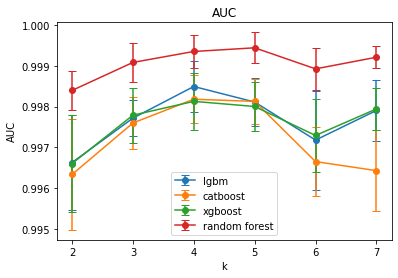

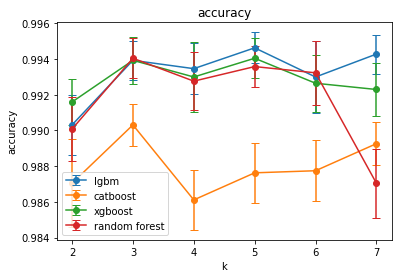

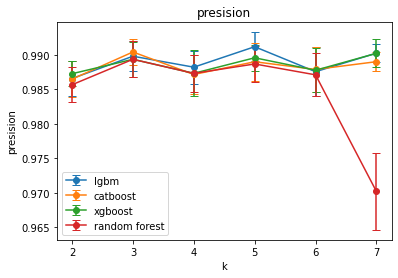

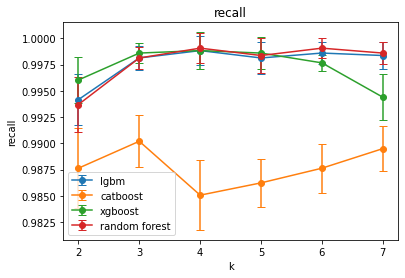

In [17]:
name_ = ['AUC', 'accuracy', 'presision', 'recall']
i=0
for arr in [auc, acc, presision, recall]:
    for name in ML_names:
        plt.errorbar(arr[name].keys(), [np.mean(arr[name][k]) for k in arr[name].keys()], 
                     yerr=[np.std(arr[name][k])/2 for k in arr[name].keys()], fmt='o-', capsize=4, label = name)
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(name_[i])
    plt.title(name_[i])
    i+=1
    plt.show()

### Chose n

In [26]:
Xn, yn = {}, {}
N = np.arange(20, 110, 10, dtype = int)
for n in N:
    Xn[n], yn[n] = gen_test_n_k_chrom(n, k = 5, chrom = 'chr10', X_3_dist = X_3_dist, neg = neg)

100%|██████████| 4284/4284 [00:32<00:00, 131.75it/s]


In [27]:
np.save('model development data/different n/X_n_k=5_all.npy', Xn)
np.save('model development data/different n/y_n_k=5_all.npy', yn)

In [18]:
Xn = np.load('model development data/different n/X_n_k=5_all.npy', allow_pickle=True).item()
yn = np.load('model development data/different n/y_n_k=5_all.npy', allow_pickle=True).item()

In [30]:
auc_n, acc_n, presision_n, recall_n = {model:{} for model in ML_names}, {model:{} for model in ML_names}, \
                              {model:{} for model in ML_names}, {model:{} for model in ML_names}
for n in N:
    X, y = Xn[n], yn[n]
    for i in tqdm(range(len(ML))):
        model = ML[i]
        name = ML_names[i]
        auc_n[name][n] = cross_val_score(model, X, y, cv=10, scoring = 'roc_auc')
        acc_n[name][n] = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
        presision_n[name][n] = cross_val_score(model, X, y, cv=10, scoring = 'precision')
        recall_n[name][n] = cross_val_score(model, X, y, cv=10, scoring = 'recall')

100%|██████████| 4/4 [18:18<00:00, 274.68s/it]


In [31]:
np.save('model development data/different n/auc_n.npy', auc_n)
np.save('model development data/different n/acc_n.npy', acc_n)
np.save('model development data/different n/presision_n.npy', presision_n)
np.save('model development data/different n/recall_n.npy', recall_n)

In [19]:
auc_n = np.load('model development data/different n/auc_n.npy', allow_pickle=True).item()
acc_n = np.load('model development data/different n/acc_n.npy', allow_pickle=True).item()
presision_n = np.load('model development data/different n/presision_n.npy', allow_pickle=True).item()
recall_n = np.load('model development data/different n/recall_n.npy', allow_pickle=True).item()

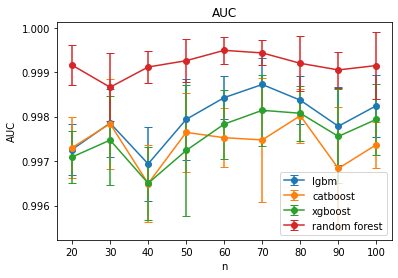

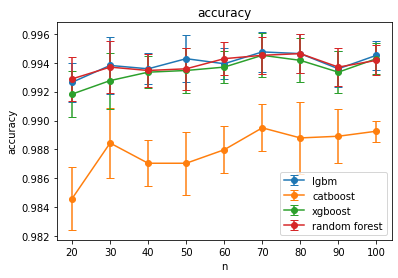

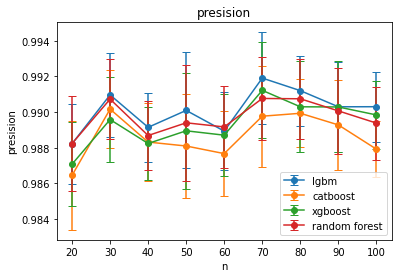

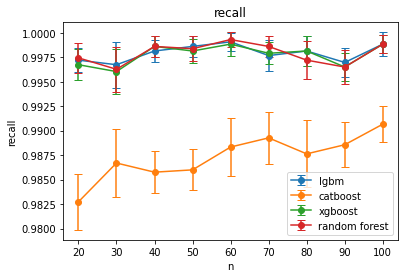

In [20]:
name_ = ['AUC', 'accuracy', 'presision', 'recall']
i=0
for arr in [auc_n, acc_n, presision_n, recall_n]:
    for name in ML_names:
        plt.errorbar(arr[name].keys(), [np.mean(arr[name][k]) for k in arr[name].keys()], 
                     yerr=[np.std(arr[name][k])/2 for k in arr[name].keys()], fmt='o-', capsize=4, label = name)
    plt.legend()
    plt.xlabel('n')
    plt.ylabel(name_[i])
    plt.title(name_[i])
    i+=1
    plt.show()

The results do not depend strongly on n but stronger on k. 
Due to the increasing duration and memory of calculations, it is worth choosing the smallest possible best n and k. 

So, we choose parameters: 
* classifier = Random Forest
* k=5
* n=70


## Comment about other classifiers: SVM and Naive Bayes

### k

Add SVM and Naive Bayes classifiers to previous 

In [6]:
Xk = np.load('model development data/different k/X_k_n=30_all.npy', allow_pickle=True).item()
yk = np.load('model development data/different k/y_k_n=30_all.npy', allow_pickle=True).item()

In [7]:
auc = np.load('model development data/different k/auc_k.npy', allow_pickle=True).item()
acc = np.load('model development data/different k/acc_k.npy', allow_pickle=True).item()
presision = np.load('model development data/different k/presision_k.npy', allow_pickle=True).item()
recall = np.load('model development data/different k/recall_k.npy', allow_pickle=True).item()

In [8]:
ML = [GaussianNB(), SVC(gamma=2, C=1)]
ML_names = ['naive bayes', 'svm']

In [9]:
for name in ML_names: 
    auc[name] = {}
    acc[name] = {}
    presision[name] = {}
    recall[name] = {}

In [10]:
K = np.arange(2, 8, dtype = int)
for k in K:
    X, y = Xk[k], yk[k]
    for i in tqdm(range(len(ML))):
        model = ML[i]
        name = ML_names[i]
        auc[name][k] = cross_val_score(model, X, y, cv=10, scoring = 'roc_auc')
        acc[name][k] = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
        presision[name][k] = cross_val_score(model, X, y, cv=10, scoring = 'precision')
        recall[name][k] = cross_val_score(model, X, y, cv=10, scoring = 'recall')

100%|██████████| 2/2 [9:39:04<00:00, 17372.41s/it]


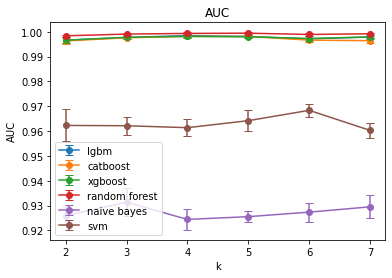

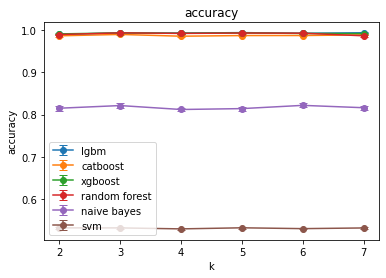

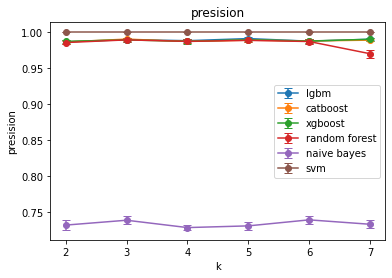

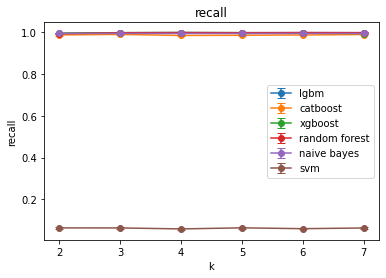

In [11]:
name_ = ['AUC', 'accuracy', 'presision', 'recall']
i=0
for arr in [auc, acc, presision, recall]:
    for name in auc.keys():
        plt.errorbar(arr[name].keys(), [np.mean(arr[name][k]) for k in arr[name].keys()], 
                     yerr=[np.std(arr[name][k])/2 for k in arr[name].keys()], fmt='o-', capsize=4, label = name)
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(name_[i])
    plt.title(name_[i])
    i+=1
    plt.show()

### n

In [11]:
Xn = np.load('model development data/different n/X_n_k=5_all.npy', allow_pickle=True).item()
yn = np.load('model development data/different n/y_n_k=5_all.npy', allow_pickle=True).item()

In [12]:
auc_n = np.load('model development data/different n/auc_n.npy', allow_pickle=True).item()
acc_n = np.load('model development data/different n/acc_n.npy', allow_pickle=True).item()
presision_n = np.load('model development data/different n/presision_n.npy', allow_pickle=True).item()
recall_n = np.load('model development data/different n/recall_n.npy', allow_pickle=True).item()

In [13]:
ML = [GaussianNB(), SVC(gamma=2, C=1)]
ML_names = ['naive bayes', 'svm']

In [14]:
for name in ML_names: 
    auc_n[name] = {}
    acc_n[name] = {}
    presision_n[name] = {}
    recall_n[name] = {}

In [15]:
N = np.arange(20, 110, 10, dtype = int)

for n in N:
    X, y = Xn[n], yn[n]
    for i in tqdm(range(len(ML))):
        model = ML[i]
        name = ML_names[i]
        auc_n[name][n] = cross_val_score(model, X, y, cv=10, scoring = 'roc_auc')
        acc_n[name][n] = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
        presision_n[name][n] = cross_val_score(model, X, y, cv=10, scoring = 'precision')
        recall_n[name][n] = cross_val_score(model, X, y, cv=10, scoring = 'recall')

100%|██████████| 2/2 [49:29<00:00, 1484.82s/it]


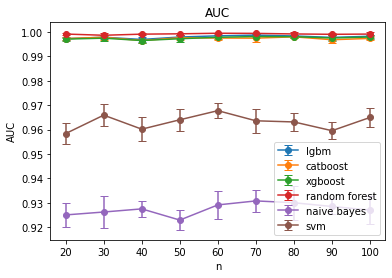

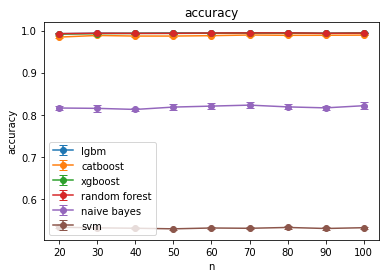

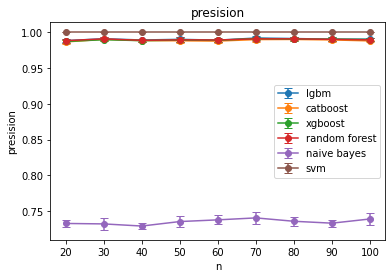

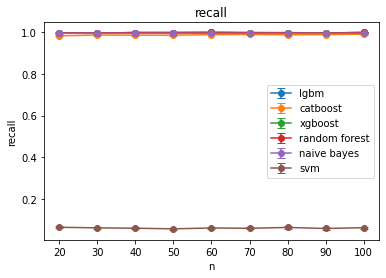

In [16]:
name_ = ['AUC', 'accuracy', 'presision', 'recall']
i=0
for arr in [auc_n, acc_n, presision_n, recall_n]:
    for name in auc_n.keys():
        plt.errorbar(arr[name].keys(), [np.mean(arr[name][k]) for k in arr[name].keys()], 
                     yerr=[np.std(arr[name][k])/2 for k in arr[name].keys()], fmt='o-', capsize=4, label = name)
    plt.legend()
    plt.xlabel('n')
    plt.ylabel(name_[i])
    plt.title(name_[i])
    i+=1
    plt.show()

As we can see, they are more worse thaen Boosts and Random Forest, therefore, we do not consider them further. 

# Pre-calculation of X and y

Now we chose n=70 and k=5, so it is nesessary to precalculate X and y for training model for all chromosomes to save time. 

In [ ]:
for chrom in hg19.keys():
    X, y = gen_test_n_k_chrom(n=70, k = 5, chrom = chrom)
    np.save('Xy for training model (n=70, k=5)/X_70_5'+chrom+'.npy', X)
    np.save('Xy for training model (n=70, k=5)/y_70_5'+chrom+'.npy', y)

Now we do not need to recalculate k-mers every time and create tables for model training because all X and y are in `Xy for training model (n=70, k=5)` folder

# All chromosomes

There we calculated AUC scores for all chromosomes and compared esults with other classifiers. 

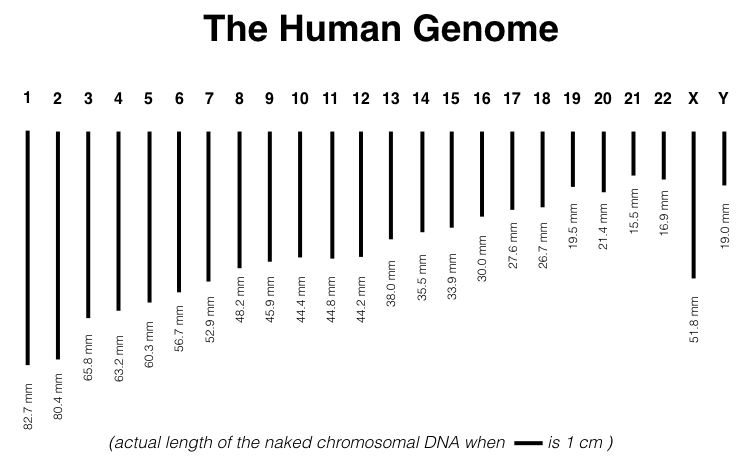

In [42]:
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 
               'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 
               'chr20', 'chr21', 'chr22', 'chrX', 'chrY']

In [43]:
ML = [RandomForestClassifier(), LGBMClassifier(), CatBoostClassifier(logging_level='Silent'), XGBClassifier(verbosity = 0)]
names = ['random forest', 'lgbm', 'catboost', 'xgboost']

In [72]:
auc_chrom = {name:{} for name in names}

In [85]:
for (model, name) in zip(ML, names):
    print(model, name)
    auc_chrom[name] = {chrom:[] for chrom in chromosomes}

    for chrom in (chromosomes):
        X = np.load('Xy for training model (n=70, k=5)/X_70_5'+chrom+'.npy')
        X = pd.DataFrame(X, columns = ['pos', *[''.join(i) for i in itertools.product('ATGC', repeat = 5)], 'dist3'])
        y = np.load('Xy for training model (n=70, k=5)/y_70_5'+chrom+'.npy')
        auc_chrom[name][chrom] = cross_val_score(model, X, y, cv=5, scoring = 'roc_auc')

RandomForestClassifier() random forest
LGBMClassifier() lgbm
<catboost.core.CatBoostClassifier object at 0x7fc96765bf70> catboost
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...) xgboost


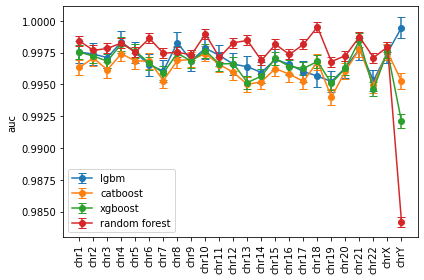

In [93]:
for name in ['lgbm', 'catboost', 'xgboost', 'random forest']: 
    plt.errorbar(auc_chrom[name].keys(), [np.mean(auc_chrom[name][chrom]) for chrom in auc_chrom[name].keys()], 
                     yerr=[np.std(auc_chrom[name][chrom])/2 for k in auc_chrom[name].keys()], fmt='o-', capsize=4, label = name)

plt.xticks(rotation = 90)
plt.ylabel('auc')
plt.legend()
plt.tight_layout()

The chromosome Y has a lower AUC value than others because of its lower size. It can be seen that the score is higher on average for longer chromosomes.

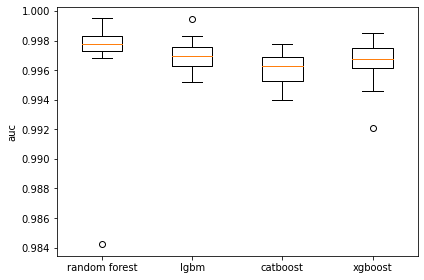

In [120]:
#boxplot for all classifiers
d = {name: list( [np.mean(auc_chrom[name][chrom]) for chrom in auc_chrom[name].keys()]) for name in names}
plt.boxplot(d.values())
plt.ylabel('auc')
plt.xticks(range(1, len(names) + 1), names)
plt.tight_layout()

We found the paper with some results for other BP-annotators and compare our results with them.

The paper: 
Signal, B., Gloss, B. S., Dinger, M. E., & Mercer, T. R. (2018). Machine learning annotation of human branchpoints. Bioinformatics (Oxford, England), 34(6), 920–927. https://doi.org/10.1093/bioinformatics/btx688 


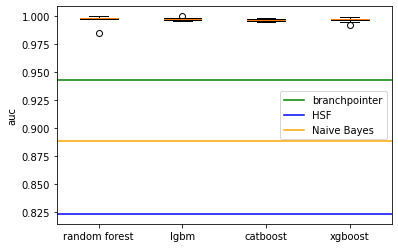

In [116]:
d = {name: list( [np.mean(auc_chrom[name][chrom]) for chrom in auc_chrom[name].keys()]) for name in names}
plt.boxplot(d.values())
plt.ylabel('auc')
plt.xticks(range(1, len(names) + 1), names)
plt.axhline(0.943, color = 'g', label = 'branchpointer')
plt.axhline(0.823, color = 'b', label = 'HSF')
plt.axhline(0.888, color = 'orange', label = 'Naive Bayes')
plt.legend()

Thus, our model shows better results compared to the previous ones. We can expect our results to be reliable